<a href="https://colab.research.google.com/github/jatinkarthik-tripathy/Senti-Analysis-Techniques/blob/main/Senti_Analysis_(ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jatinkarthikt","key":"ec224a00f8c304a2954f9c16bae211a4"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d bittlingmayer/amazonreviews --force

 97% 477M/493M [00:04<00:00, 95.6MB/s]
100% 493M/493M [00:05<00:00, 102MB/s] 


In [6]:
!unzip amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [1]:
import bz2
train_file = bz2.BZ2File('/content/test.ft.txt.bz2')
test_file = bz2.BZ2File('/content/train.ft.txt.bz2')

In [2]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [3]:
import numpy as np 
import pandas as pd 
import bz2
import gc
import chardet
import re
import os

#Pre-Processing

In [4]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines]

for i in range(len(train_sentences)):
    train_sentences[i] = re.sub('\d','0',train_sentences[i])
    
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_file_lines]

for i in range(len(test_sentences)):
    test_sentences[i] = re.sub('\d','0',test_sentences[i])
                                                       
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])
        
for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [5]:
train_sentences[:5]

['great cd: my lovely pat has one of the great voices of her generation. i have listened to this cd for years and i still love it. when i\'m in a good mood it makes me feel better. a bad mood just evaporates like sugar in the rain. this cd just oozes life. vocals are jusat stuunning and lyrics just kill. one of life\'s hidden gems. this is a desert isle cd in my book. why she never made it big is just beyond me. everytime i play this, no matter black, white, young, old, male, female everybody says one thing "who was that singing ?"',
 "one of the best game music soundtracks - for a game i didn't really play: despite the fact that i have only played a small portion of the game, the music i heard (plus the connection to chrono trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. there is an incredible mix of fun, epic, and emotional songs. those sad and beautiful tracks i especially like, as there's not too many of those kinds of s

In [6]:
train_labels[:5]

[1, 1, 0, 1, 1]

In [7]:
!pip install eli5

#Sklearn Imports

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

#Vectorization

In [9]:
print(len(train_sentences))
train_sentences_batches = np.array_split(train_sentences, 20)
train_labels_batches = np.array_split(train_labels, 20)
print(len(train_sentences_batches[0]))
print(len(train_labels_batches[0]))

400000
20000
20000


In [ ]:
test_sentences_batches = np.array_split(test_sentences, 20)
test_labels_batches = np.array_split(test_labels, 20)
print(len(test_sentences_batches[0]))
print(len(test_labels_batches[0]))

In [ ]:
transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3), 
                              lowercase=True, max_features=100000)

#Util Fns

In [ ]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_pr_re(fit_model, X_valid, y_valid):
  disp = plot_precision_recall_curve(fit_model, X_valid, y_valid)
  disp.ax_.set_title('Precision-Recall Curve')

In [ ]:
import sklearn.metrics as metrics
def plot_roc(y_valid, pred):
  fpr, tpr, threshold = metrics.roc_curve(y_valid, pred)
  roc_auc = metrics.auc(fpr, tpr)

  # method I: plt
  import matplotlib.pyplot as plt
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

#General Train Fn

In [ ]:
def prediction(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    f1 = f1_score(y_valid, pred)
    conf = confusion_matrix(y_valid, pred)
    return model, acc, f1, conf, pred

#Logistic Regression [Baseline Model]

In [ ]:
for i in range(10):
  print(f'Batch {i}')
  print('--------------------------------------------')
  X = transformer.fit_transform(train_sentences_batches[i])
  y = train_labels_batches[i]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
  model = LogisticRegression(C=1, random_state=42, n_jobs=-1)
  fit_model, acc, f1, conf, pred = prediction(model, X_train, y_train, X_valid, y_valid)
  print(f"Accuracy: {acc:.5f}")
  print(f"F1_Score: {f1:.5f}")
  print(f"Confusion Matrix: {conf}")
  print('--------------------------------------------')

Batch 0
--------------------------------------------
Accuracy: 0.86500
F1_Score: 0.86963
Confusion Matrix: [[1659  298]
 [ 242 1801]]
--------------------------------------------
Batch 1
--------------------------------------------
Accuracy: 0.85800
F1_Score: 0.85975
Confusion Matrix: [[1691  280]
 [ 288 1741]]
--------------------------------------------
Batch 2
--------------------------------------------
Accuracy: 0.86575
F1_Score: 0.86456
Confusion Matrix: [[1749  257]
 [ 280 1714]]
--------------------------------------------
Batch 3
--------------------------------------------
Accuracy: 0.86600
F1_Score: 0.87177
Confusion Matrix: [[1642  285]
 [ 251 1822]]
--------------------------------------------
Batch 4
--------------------------------------------
Accuracy: 0.87225
F1_Score: 0.87099
Confusion Matrix: [[1764  259]
 [ 252 1725]]
--------------------------------------------
Batch 5
--------------------------------------------
Accuracy: 0.87250
F1_Score: 0.87469
Confusion Matrix

In [ ]:
import eli5
eli5.show_weights(estimator=fit_model, 
                  feature_names= list(transformer.get_feature_names()),
                    top=(20,20))

###Logreg [Baseline] Results

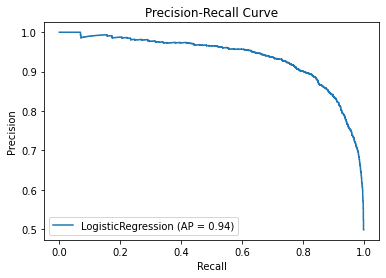

In [ ]:
plot_pr_re(fit_model, X_valid, y_valid)

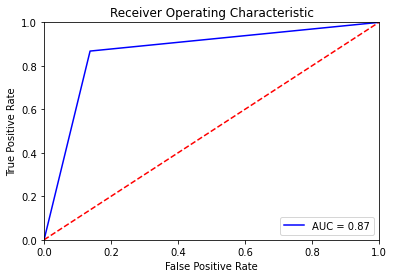

In [ ]:
plot_roc(y_valid, pred)

#SVM

In [ ]:
from sklearn.svm import SVC
for i in range(10):
  print(f'Batch {i}')
  print('--------------------------------------------')
  X = transformer.fit_transform(train_sentences_batches[i])
  y = train_labels_batches[i]
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
  model = SVC()
  fit_model, acc, f1, conf, pred = prediction(model, X_train, y_train, X_valid, y_valid)
  print(f"Accuracy: {acc:.5f}")
  print(f"F1_Score: {f1:.5f}")
  print(f"Confusion Matrix: {conf}")
  print('--------------------------------------------')

Batch 0
--------------------------------------------
Accuracy: 0.86300
F1_Score: 0.86821
Confusion Matrix: [[1647  310]
 [ 238 1805]]
--------------------------------------------
Batch 1
--------------------------------------------
Accuracy: 0.86275
F1_Score: 0.86441
Confusion Matrix: [[1701  270]
 [ 279 1750]]
--------------------------------------------
Batch 2
--------------------------------------------
Accuracy: 0.86825
F1_Score: 0.86749
Confusion Matrix: [[1748  258]
 [ 269 1725]]
--------------------------------------------
Batch 3
--------------------------------------------
Accuracy: 0.86850
F1_Score: 0.87392
Confusion Matrix: [[1651  276]
 [ 250 1823]]
--------------------------------------------
Batch 4
--------------------------------------------
Accuracy: 0.87525
F1_Score: 0.87409
Confusion Matrix: [[1769  254]
 [ 245 1732]]
--------------------------------------------
Batch 5
--------------------------------------------
Accuracy: 0.87675
F1_Score: 0.87920
Confusion Matrix

In [ ]:
X = transformer.fit_transform(train_sentences_batches[5])
y = train_labels_batches[5]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, 
                                                      random_state=42, stratify=y)
model = SVC()
fit_model, acc, f1, conf, pred = prediction(model, X_train, y_train, X_valid, y_valid)
print(f"Accuracy: {acc:.5f}")
print(f"F1_Score: {f1:.5f}")
print(f"Confusion Matrix: {conf}")

Accuracy: 0.87675
F1_Score: 0.87920
Confusion Matrix: [[1713  272]
 [ 221 1794]]


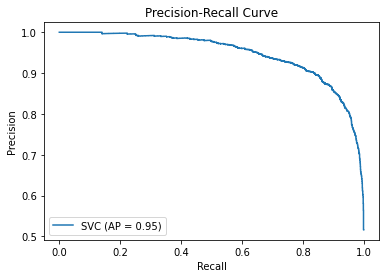

In [ ]:
plot_pr_re(fit_model, X_valid, y_valid)

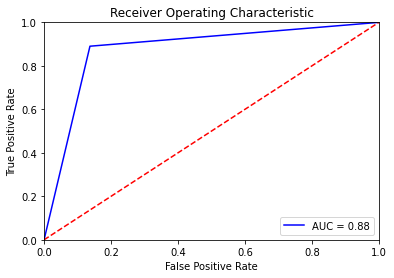

In [ ]:
plot_roc(y_valid, pred)

#BERT


In [10]:
!pip install --upgrade tensorflow-hub

Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.6/dist-packages (0.10.0)


In [11]:
!pip install transformers

In [14]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(train_sentences_batches[0], train_labels_batches[0], test_size=.2)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.1)


In [15]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [18]:
import tensorflow as tf
train_texts = [str(txt) for txt in train_texts]
val_texts = [str(txt) for txt in val_texts]
test_texts = [str(txt) for txt in test_texts]

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [19]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=50,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=4,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

with training_args.strategy.scope():
    model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

KeyboardInterrupt: ignored